In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from deribitv2 import DeriBit
import warnings
warnings.simplefilter("ignore")

In [7]:
def compute_profit(trade_hist):
    test = pd.DataFrame(trade_hist)
    test["sell"] = test["amount"].copy()
    test["sell"][test["direction"] != "sell"] = 0

    test["buy"] = test["amount"].copy()
    test["buy"][test["direction"]!="buy"] = 0

    test["weighted_buy"] = test["price"] * test["buy"]
    test["weighted_sell"] = test["price"] * test["sell"]

    test["weighted_buy"][test["weighted_buy"]==0] = float("NaN")
    test["weighted_sell"][test["weighted_sell"]==0] = float("NaN")
    return np.nansum(test["weighted_buy"]) / np.nansum(test["buy"]), np.nansum(test["weighted_sell"]) / np.nansum(test["sell"]), np.nansum(test["buy"]), np.nansum(test["sell"])

def compensate_imbalance(trade_hist):
    avg_buy, avg_sell, vol_buy, vol_sell = compute_profit(trade_hist)
    try:
        print(f" {avg_buy} x {vol_buy} | {avg_sell} x {vol_sell} | net: {vol_buy - vol_sell}")
        if vol_buy > vol_sell:
            avg_sell = (vol_sell * avg_sell + (vol_buy-vol_sell) * trade_hist[0]["price"]) / vol_buy
        if vol_sell > vol_buy:
            avg_buy = (vol_buy * avg_buy + (vol_sell-vol_buy) * trade_hist[0]["price"]) / vol_sell
        print(avg_buy, avg_sell)
        print(f"price difference | {round((avg_sell - avg_buy)/avg_buy * 100, 4)}%")
        print(f"profit | {max(vol_buy, vol_sell) * (avg_sell - avg_buy) / avg_buy}")
        return (avg_sell - avg_buy)/avg_buy, vol_buy + vol_sell
    except:
        return None, None


In [8]:
def view_recent_activity(look_back, t_back):
    fig, axs = plt.subplots(3,1, figsize= (15,15))
    # res = d.getpricehistory("ETH-PERPETUAL", start_timestamp=int((time.time() - 10 * 3600)*1000), end_timestamp=int(time.time() * 1000), delta = '1')
    
    completed_trades = d.getlasttrades(f"{asset}-PERPETUAL", count = look_back)
    # print(compute_profit(completed_trades["trades"]))
    compensate_imbalance(completed_trades["trades"])

    private_completed_trades = d.tradehistory(f"{asset}-PERPETUAL", countNum = t_back)
    # private_completed_trades = d.tradehistory_bytime("ETH-PERPETUAL", start_timestamp = int((time.time() - t_back) * 1000), end_timestamp = int((time.time()+60) * 1000))
    # plot historic prices
    # df = pd.DataFrame(res).set_index("ticks", drop = True)
    # df.index = pd.to_datetime(df.index, unit = "ms")

    # for column in ["high", "low", "close"]:
    #     axs.plot(df.index, df[column], color = 'blue') 

    def order_trades(completed_trades):
        # order executed trades
        bought = []
        sold = []
        for trade in completed_trades['trades']:
            if trade["direction"] == "buy":
                bought.append([trade["timestamp"], trade["price"]])
            if trade["direction"] == "sell":
                sold.append([trade["timestamp"], trade["price"]])        
        bought = pd.DataFrame(bought)
        sold = pd.DataFrame(sold)
        bought = bought.set_index(0, drop = True)
        bought.index = pd.to_datetime(bought.index, unit = "ms")
        sold = sold.set_index(0, drop = True)
        sold.index = pd.to_datetime(sold.index, unit = "ms")
        return bought, sold

    bought, sold = order_trades(completed_trades)
    bought_priv, sold_priv = order_trades(private_completed_trades)
    trades_priv = d.gettransactionlog(asset, int((time.time()-t_look_back)*1000), int(time.time()*1000), 100000)
    eq = np.array([tr["equity"] for tr in trades_priv["logs"]])
    eq = np.flip(eq)
    
    def wma(array):
        if len(array) == 0:
            return float("NaN")
        return sum( [r[0]*r[1] for r in array] ) / sum( [r[0] for r in array] )
        # ma_sum = 0
        # weight = 0
        # for row in array:
        #     ma_sum += row[0] * row[1]
        #     weight += row[0]
        # return ma_sum / weight

    # plot executec trades
    axs[0].scatter(sold.index, sold[1], color = 'red', s = 2)
    axs[0].scatter(bought.index, bought[1], color = 'green', s = 2)

    # print(f"avg buy: {wma(np.array(bought))} | avg sell: {wma(np.array(sold))}")

    axs[0].scatter(sold_priv.index, sold_priv[1], color = 'red', s = 50)
    axs[0].scatter(bought_priv.index, bought_priv[1], color = 'green', s = 50)
    # axs.set_xlim(pd.to_datetime(time.time() - look_back, unit = 's'), pd.to_datetime(time.time(), unit = 's'))
    # axs.set_ylim(y_min, y_max)
    
    axs[0].grid()
    dates = [pd.to_datetime(trade["timestamp"], unit = 'ms') for trade in private_completed_trades['trades']]
    dates.reverse()

    cumsum = [trade['profit_loss'] for trade in private_completed_trades['trades']]
    cumsum.reverse()
    cumsum = np.array(cumsum)
    axs[1].plot(dates, cumsum.cumsum())

    direction = {
        "buy": 1,
        "sell": -1,
    }
    t = [trade["amount"]*direction[trade["direction"]] for trade in private_completed_trades['trades']]
    t.reverse()
    trade_sizes = np.array(t).cumsum()
    axs[2].scatter(dates,trade_sizes)

    axs[1].grid()
    axs[2].grid()
    plt.show()

    plt.plot(eq)
    plt.show()
    
    fig, ax = plt.subplots(1,1, figsize = (25,20))
    ax.scatter(sold.index, sold[1], color = 'red', s = 2)
    ax.scatter(bought.index, bought[1], color = 'green', s = 2)
    ax.grid()
    plt.show()

    return private_completed_trades, completed_trades

 1861.2920342102402 x 1095403.0 | 1861.6136569178727 x 1843681.0 | net: -748278.0
1861.5793698313319 1861.6136569178727
price difference | 0.0018%
profit | 33.95742938776105


KeyError: 'None of [0] are in the columns'

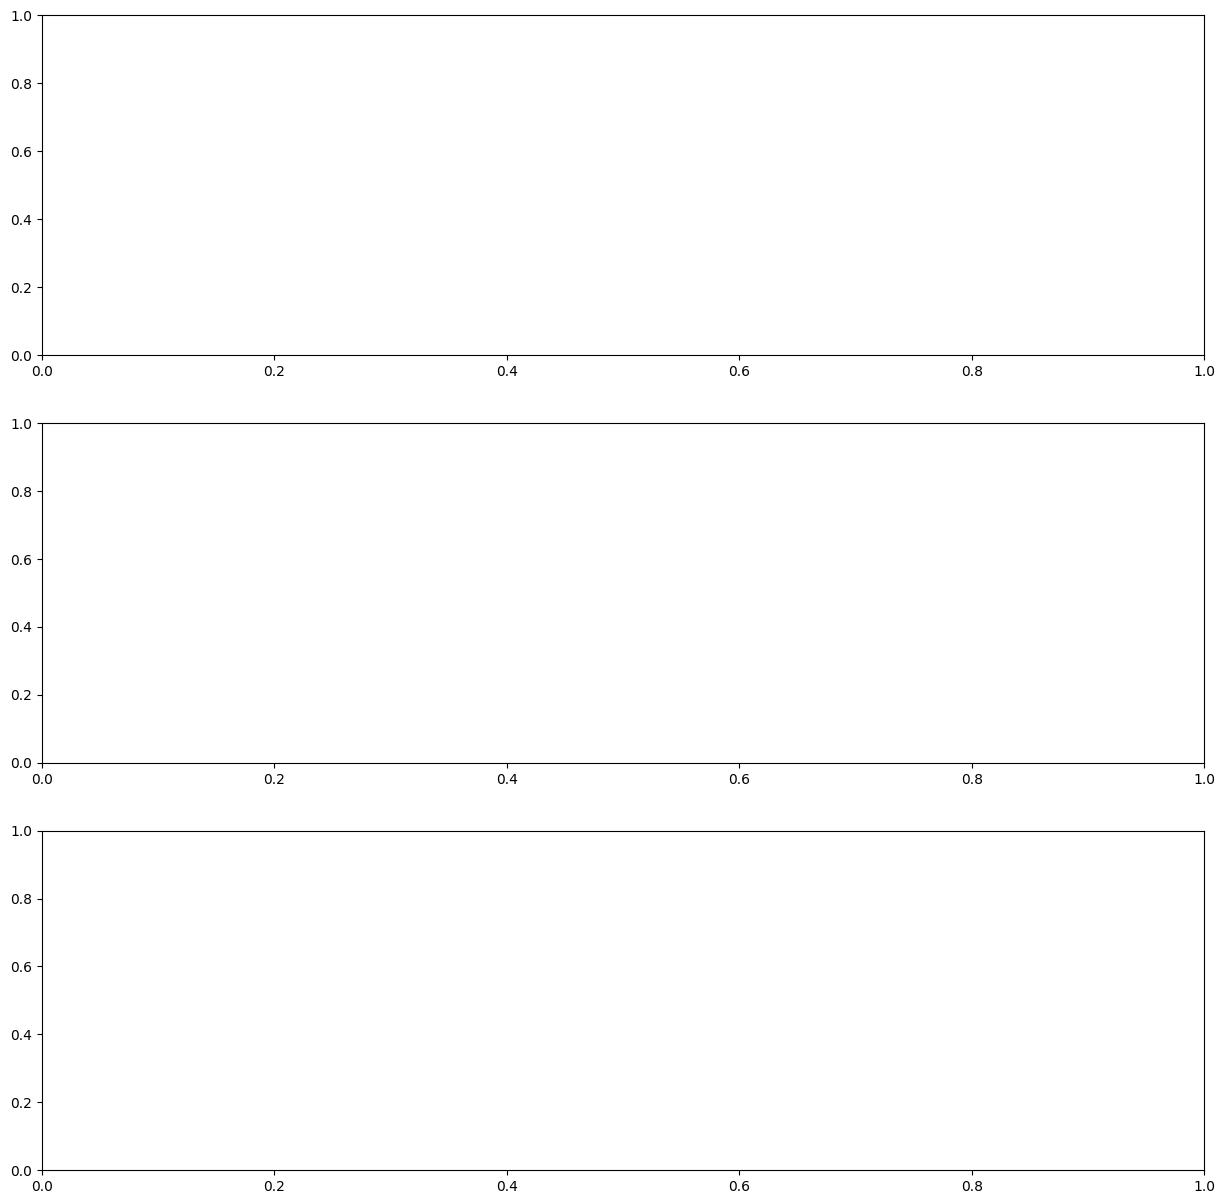

In [9]:
d = DeriBit()
d.getauth()
asset = 'eth'.upper()
t_look_back = 3600 * 10
res, res1 = view_recent_activity(1000, t_back=500) # 425
trades_f = res['trades']
bought = [[trade["amount"], trade["price"]] for trade in trades_f if trade["direction"]== "buy"]
sold = [[trade["amount"], trade["price"]] for trade in trades_f if trade["direction"] =="sell"]
bought_vol = sum(t[0] for t in bought)
sold_vol = sum(t[0] for t in sold)

def wma(array):
    ma_sum = 0
    weight = 0
    for row in array:
        ma_sum += row[0] * row[1]
        weight += row[0]
    return ma_sum / weight
print(f"avg buy: {wma(np.array(bought))} x {bought_vol} | avg sell: {wma(np.array(sold))} x {sold_vol}")
round((wma(np.array(sold)) - wma(np.array(bought)) ) / wma(np.array(bought))*100, 5)